# LAB1

#### Импорты и объявления

In [17]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt

In [18]:
TEST = pd.read_csv("https://raw.githubusercontent.com/soules-one/ML/refs/heads/main/lab1/test.csv")
TRAIN = pd.read_csv("https://raw.githubusercontent.com/soules-one/ML/refs/heads/main/lab1/train.csv")

#### Задание

Нормализация

In [19]:
def z_score_1d(x):
    x = np.array(x)
    mn = x.mean()
    st = x.std()
    return (x - mn) / st

def z_score(X):
    mn = np.mean(X, axis=0)
    st = np.std(X, axis=0)
    st[st == 0] = 1
    return (X - mn) / st, [mn, st]

def z_scoreP(X, mn, st):
    st[st == 0] = 1
    return (X - mn) / st

def min_max(X):
    mn = np.min(X, axis=0)
    mx = np.max(X, axis=0)
    r = mx - mn
    r[r == 0] = 1
    return (X - mn) / r, [mn, mx]

def min_maxP(X, mn, mx):
    r = mx - mn
    r[r == 0] = 1
    return (X - mn) / r

Оценки

In [20]:
def MSE(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    score = np.float64(0)
    if len(y_pred) != len(y_true):
        raise ValueError
    n = len(y_true)
    for i in range(n):
        score += (y_true[i] - y_pred[i]) ** 2
    return score / n

def MAE(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    score = np.float64(0)
    if len(y_pred) != len(y_true):
        raise ValueError
    n = len(y_true)
    for i in range(n):
        score += np.abs(y_true[i] - y_pred[i])
    return score / n

def MAPE(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    score = np.float64(0)
    if len(y_pred) != len(y_true):
        raise ValueError
    n = len(y_true)
    return np.sum(np.abs((y_true - y_pred) / y_true))

def R2(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    score = np.float64(1)
    if len(y_pred) != len(y_true):
        raise ValueError
    n = len(y_true)
    num = np.float64(0)
    den = np.float64(0)
    y_mn = np.mean(y_true)
    for i in range(n):
        num += (y_true[i] - y_pred[i]) ** 2
        den += (y_true[i] - y_mn) ** 2
    if den == 0:
        den = 1
    score -= num / den
    return score

### Реализация LinReg

In [21]:
class LinReg():
    class FType:
        An = 1
        GD = 2
        SGD = 3
    class Normalize:
        No_Norm = 0
        Z_Score = 1
        Min_Max = 2

    def __init__(self, f=FType.An, norm=Normalize.No_Norm, eps=1e-10, epochs=None, step=None):
        if (
            f not in [self.FType.An, self.FType.GD, self.FType.SGD] or
            norm not in [self.Normalize.No_Norm, self.Normalize.Min_Max, self.Normalize.Z_Score]
            ):
            raise ValueError
        self.W = None
        self.n = 0
        self.nt = norm
        self.f = f
        self.eps = eps
        self.epochs = epochs
        self.step = step
        self.norm = None
    
    def fit(self, X, y):
        t = np.empty_like(X)
        if X.shape[0] != len(y):
            raise ValueError
        self.n = len(y)
        norm = self.nt
        if norm != self.Normalize.No_Norm:
            if norm == self.Normalize.Z_Score:
                X, self.norm = z_score(X)
            else:
                X, self.norm = min_max(X)
        X = np.hstack((np.ones((self.n, 1)), X))
        m = X.shape[1]
        self.W = np.random.randn(m) * 0.01
        f = self.f
        step = self.step
        eps = self.eps
        epochs = self.epochs
        if f == self.FType.An:
            try:
                self.W = np.linalg.solve(X.T @ X, X.T @ y)
            except np.linalg.LinAlgError:
                Q, R = np.linalg.qr(X, mode='reduced')
                self.W = np.linalg.lstsq(R, Q.T @ y, rcond=None)[0]
        elif f == self.FType.GD:
            if epochs is None:
                epochs = True
            k = 1
            while epochs:
                p = self.W
                curr = X @ self.W
                grad = (1/self.n) * (curr - y) @ X
                self.W -= (1 / k if step is None else step) * grad
                if np.linalg.norm(grad) < eps or np.linalg.norm(self.W - p) < eps:
                    return self
                k += 1
                if epochs is not True:
                    epochs -= 1
            return self
        else:
            if epochs is None:
                epochs = True
            k = 1
            while epochs:
                idx = np.random.randint(0, self.n)
                xi = X[idx, :]
                yi = y[idx]
                p = self.W
                grad = ((xi @ self.W) - yi) * xi
                self.W -= (1 / k if step is None else step) * grad
                if np.linalg.norm(grad) < eps or np.linalg.norm(self.W - p) < eps:
                    return self
                k += 1
                if epochs is not True:
                    epochs -= 1
            return self

    
    def predict(self, X):
        X = np.array(X)
        if self.nt != self.Normalize.No_Norm:
            if self.nt == self.Normalize.Z_Score:
                X = z_scoreP(X, *self.norm)
            else:
                X = min_maxP(X, *self.norm)
        X = np.hstack((np.ones((X.shape[0], 1)), X))
        if self.W is None or X.shape[1] != self.W.shape[0]:
            raise ValueError
        return (X @ self.W).flatten()


In [22]:
class LinRegL2():
    class FType:
        An = 1
        GD = 2
        SGD = 3
    class Normalize:
        No_Norm = 0
        Z_Score = 1
        Min_Max = 2

    def __init__(self, lam=0.1, f=FType.GD, norm=Normalize.No_Norm,
                 eps=1e-10, epochs=None, step=None):

        if (
            f not in [self.FType.An, self.FType.GD, self.FType.SGD] or
            norm not in [self.Normalize.No_Norm, self.Normalize.Min_Max, self.Normalize.Z_Score]
        ):
            raise ValueError

        self.lam = lam
        self.W = None
        self.n = 0
        self.nt = norm
        self.f = f
        self.eps = eps
        self.epochs = epochs
        self.step = step
        self.norm = None

    def fit(self, X, y):
        if X.shape[0] != len(y):
            raise ValueError

        self.n = len(y)

        if self.nt != self.Normalize.No_Norm:
            if self.nt == self.Normalize.Z_Score:
                X, self.norm = z_score(X)
            else:
                X, self.norm = min_max(X)

        X = np.hstack((np.ones((self.n, 1)), X))
        m = X.shape[1]
        self.W = np.random.randn(m) * 0.01

        lam = self.lam
        f = self.f
        step = self.step
        eps = self.eps
        epochs = self.epochs

        if f == self.FType.An:
            I = np.eye(m)
            I[0,0] = 0
            self.W = np.linalg.solve(X.T @ X + lam * I, X.T @ y)

        elif f == self.FType.GD:
            if epochs is None:
                epochs = True

            k = 1
            while epochs:
                p = self.W
                curr = X @ self.W

                reg = lam * self.W
                reg[0] = 0

                grad = (1/self.n) * ((curr - y) @ X) + reg

                self.W -= (1 / k if step is None else step) * grad

                if np.linalg.norm(grad) < eps or np.linalg.norm(self.W - p) < eps:
                    return self

                k += 1
                if epochs is not True:
                    epochs -= 1

        else:
            if epochs is None:
                epochs = True

            k = 1
            while epochs:
                idx = np.random.randint(0, self.n)
                xi = X[idx,:]
                yi = y[idx]

                p = self.W

                reg = lam * self.W
                reg[0] = 0

                grad = ((xi @ self.W - yi) * xi) + reg

                self.W -= (1 / k if step is None else step) * grad

                if np.linalg.norm(grad) < eps or np.linalg.norm(self.W - p) < eps:
                    return self

                k += 1
                if epochs is not True:
                    epochs -= 1

        return self

    def predict(self, X):
        X = np.array(X)

        if self.nt != self.Normalize.No_Norm:
            if self.nt == self.Normalize.Z_Score:
                X = z_scoreP(X, *self.norm)
            else:
                X = min_maxP(X, *self.norm)

        X = np.hstack((np.ones((X.shape[0],1)), X))

        if self.W is None or X.shape[1] != self.W.shape[0]:
            raise ValueError

        return (X @ self.W).flatten()


In [23]:
class LinRegL1():
    class FType:
        GD = 2
        SGD = 3
    class Normalize:
        No_Norm = 0
        Z_Score = 1
        Min_Max = 2

    def __init__(self, lam=0.1, f=FType.GD, norm=Normalize.No_Norm,
                 eps=1e-18, epochs=None, step=None):

        if (
            f not in [self.FType.GD, self.FType.SGD] or
            norm not in [self.Normalize.No_Norm, self.Normalize.Min_Max, self.Normalize.Z_Score]
        ):
            raise ValueError

        self.lam = lam
        self.W = None
        self.n = 0
        self.nt = norm
        self.f = f
        self.eps = eps
        self.epochs = epochs
        self.step = step
        self.norm = None

    def fit(self, X, y):
        if X.shape[0] != len(y):
            raise ValueError

        self.n = len(y)

        if self.nt != self.Normalize.No_Norm:
            if self.nt == self.Normalize.Z_Score:
                X, self.norm = z_score(X)
            else:
                X, self.norm = min_max(X)

        X = np.hstack((np.ones((self.n,1)), X))
        m = X.shape[1]
        self.W = np.random.randn(m) * 0.01

        lam = self.lam
        f = self.f
        step = self.step
        eps = self.eps
        epochs = self.epochs

        if epochs is None:
            epochs = True

        k = 1
        while epochs:

            if f == self.FType.GD:
                curr = X @ self.W
                grad = (1/self.n) * ((curr - y) @ X)

            else:
                idx = np.random.randint(0, self.n)
                xi = X[idx,:]
                yi = y[idx]
                grad = (xi @ self.W - yi) * xi

            l1 = lam * np.sign(self.W)
            l1[0] = 0

            grad = grad + l1

            p = self.W
            self.W -= (1 / k if step is None else step) * grad

            if np.linalg.norm(grad) < eps or np.linalg.norm(self.W - p) < eps:
                return self

            k += 1
            if epochs is not True:
                epochs -= 1

        return self

    def predict(self, X):
        X = np.array(X)

        if self.nt != self.Normalize.No_Norm:
            if self.nt == self.Normalize.Z_Score:
                X = z_scoreP(X, *self.norm)
            else:
                X = min_maxP(X, *self.norm)

        X = np.hstack((np.ones((X.shape[0],1)), X))

        if self.W is None or X.shape[1] != self.W.shape[0]:
            raise ValueError

        return (X @ self.W).flatten()


Кросс-валидация

In [24]:
class KFold:
    def __init__(self, n, r_state=None):
        if n < 2 or (r_state is not None and (not isinstance(r_state, int) or r_state < 0)):
            raise ValueError
        self.n = n
        if r_state is not None  :
            self.seed = r_state
        else:
            self.seed = np.random.randint(0, 1000000)
    
    def create_splits(self, X, Y):
        if self.n > len(X) or len(X) != len(Y):
            raise ValueError
        splits = []
        perm = np.random.RandomState(seed=self.seed).permutation(np.arange(len(Y)))
        l = int(np.floor(len(X) / self.n))
        for k in range(self.n - 1):
            fold = np.zeros((len(X)), dtype=bool)
            kf = np.zeros((len(X)), dtype=bool)
            fold[perm[k * l: (k + 1) * l]] = True
            kf[perm[:k * l]] = True
            kf[perm[(k + 1) * l: ]] = True
            splits.append([kf, fold])
        fold = np.zeros((len(X)), dtype=bool)
        kf = np.zeros((len(X)), dtype=bool)
        fold[perm[(self.n - 1) * l:]] = True
        kf[perm[:(self.n) * l]] = True
        splits.append([kf, fold])
        return splits, self.seed
    
class LOO:
    def __init__(self, r_state=None):
        if (r_state is not None and (not isinstance(r_state, int) or r_state < 0)):
            raise ValueError
        if r_state is not None  :
            self.seed = r_state
        else:
            self.seed = np.random.randint(0, 1000000)

    def create_splits(self, X, Y):
        kf = KFold(len(X), self.seed)
        return kf.create_splits(X, Y)
    
class KValidator:
    def __init__(self, modelcls, params, splitter, F=MSE):
        if not isinstance(splitter, KFold) and not isinstance(splitter, LOO):
            raise ValueError
        self.splitter = splitter
        self.F = F
        self.modelcls = modelcls
        self.params = params
    
    def cross_validate(self, X, Y):
        X = np.array(X)
        Y = np.array(Y, dtype=np.float64)
        splits, _ = self.splitter.create_splits(X, Y)
        bestq = np.inf
        bestp = None
        for param in self.params:
            model = self.modelcls(**param)
            q = np.float64(0)
            for i in splits:
                x_train = X[i[0]]
                y_train = Y[i[0]]
                x_test = X[i[1]]
                y_test = Y[i[1]]
                model.fit(x_train, y_train)
                pred = model.predict(x_test)
                sc = self.F(y_test, pred)
                q += sc
            q = q / len(splits)
            if q < bestq:
                bestq = q
                bestp = param
        return bestq, bestp
    

            

### Визуализация

      ApplicationDate   Age  AnnualIncome  CreditScore  LoanAmount  \
0          2010-06-26  27.0       66829.0        549.0     17290.0   
1          1996-09-23  55.0      172147.0        850.0     16110.0   
2          2015-01-19  51.0      300000.0        850.0     38436.0   
3          1981-05-12  25.0       34683.0        847.0     19186.0   
4          1995-05-07  55.0      300000.0        850.0     30437.0   
...               ...   ...           ...          ...         ...   
11010      1984-09-26  47.0       88686.0        648.0      5472.0   
11011      1980-01-15  39.0      300000.0        850.0      7721.0   
11012      2010-07-10  57.0      300000.0        850.0     14756.0   
11013      2003-10-22  28.0       15000.0        300.0     51361.0   
11014      1983-05-12  23.0       15000.0        302.0     30724.0   

       LoanDuration MaritalStatus  NumberOfDependents HomeOwnershipStatus  \
0              60.0      Divorced                 1.0                Rent   
1    

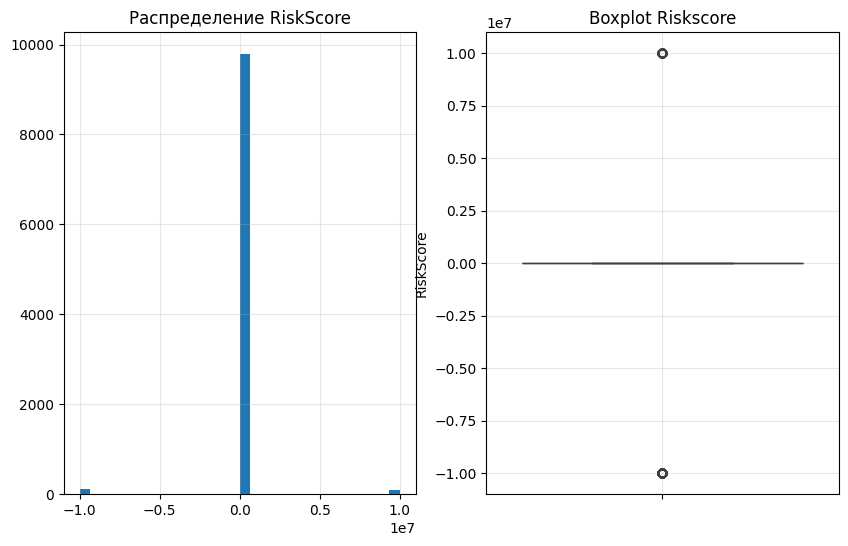

In [25]:
plt.figure(figsize=(10, 6))

df = TRAIN
df = df.dropna() # избавляемся от неполных данных
print(df)
print(df["MaritalStatus"].unique())
print(df["HomeOwnershipStatus"].unique())
print(df["LoanPurpose"].unique())
print(df["EmploymentStatus"].unique())
print(df["EducationLevel"].unique())
def visualise_df(df):
    plt.subplot(1, 2, 1)
    plt.hist(df['RiskScore'], bins=30)
    plt.title('Распределение RiskScore')
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    sns.boxplot(df['RiskScore'])
    plt.title('Boxplot Riskscore')
    plt.grid(True, alpha=0.3)
    plt.show()

visualise_df(df)
# Видим выбросы

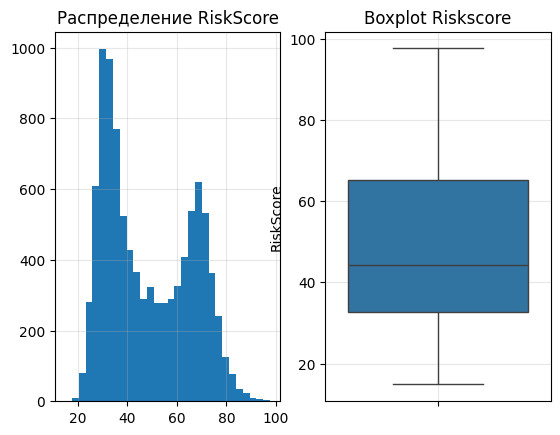

In [26]:

# для поиска выбросов будем использовать z-score

sc = np.abs(z_score_1d(df["RiskScore"]))
df = df[sc < 3]
visualise_df(df)

# Приведём данные к числовому виду

def transform_df(X):
    cols = ["MaritalStatus", "HomeOwnershipStatus", "LoanPurpose", "EmploymentStatus", "EducationLevel"]
    #df["ApplicationYear"] = pd.to_datetime(df["ApplicationDate"]).dt.year.astype(int)
    #df["ApplicationMonth"] = pd.to_datetime(df["ApplicationDate"]).dt.month.astype(int)
    #df["ApplicationQuarter"] = pd.to_datetime(df["ApplicationDate"]).dt.quarter.astype(int)
    #df = df.drop(columns="ApplicationDate")
    X["ApplicationDate"] = pd.to_datetime(X['ApplicationDate']).astype(int)
    if "MaritalStatus" in X.columns:
        X = pd.get_dummies(X, columns=['MaritalStatus'], prefix='Marital', drop_first=True, dtype=int)
    if "HomeOwnershipStatus" in X.columns:
        X = pd.get_dummies(X, columns=['HomeOwnershipStatus'], prefix='OWN', drop_first=True, dtype=int)
    if "LoanPurpose" in X.columns:
        X = pd.get_dummies(X, columns=['LoanPurpose'], prefix='PURP', drop_first=True, dtype=int)
    if "EmploymentStatus" in X.columns:
        X = pd.get_dummies(X, columns=['EmploymentStatus'], prefix='EMP', drop_first=True, dtype=int)
    if "EducationLevel" in X.columns:
        X = pd.get_dummies(X, columns=['EducationLevel'], prefix='EDU', drop_first=True, dtype=int)
    return X.drop(columns=cols, errors="ignore")

df = transform_df(df)


In [ ]:
correlation_matrix = df.corr(method='pearson')
print("Матрица корреляций Пирсона:")
print(correlation_matrix)

plt.figure(figsize=(30, 30))
sns.heatmap(correlation_matrix, annot=True, fmt='.4f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Матрица корреляций', fontsize=16, pad=20)
plt.tight_layout()
plt.show()



Матрица корреляций Пирсона:
                            ApplicationDate       Age  AnnualIncome  \
ApplicationDate                    1.000000 -0.001086     -0.002111   
Age                               -0.001086  1.000000      0.039471   
AnnualIncome                      -0.002111  0.039471      1.000000   
CreditScore                        0.003007  0.056968      0.617930   
LoanAmount                         0.005690  0.006178      0.002974   
LoanDuration                      -0.003516  0.019498     -0.017199   
NumberOfDependents                -0.007998  0.018494     -0.004079   
MonthlyDebtPayments                0.022560 -0.013430      0.010828   
CreditCardUtilizationRate          0.021275  0.026346     -0.009095   
NumberOfOpenCreditLines            0.014765 -0.003938      0.003477   
NumberOfCreditInquiries            0.023768 -0.001098      0.014758   
DebtToIncomeRatio                 -0.019040 -0.005035      0.009278   
BankruptcyHistory                  0.006996  0.00

In [ ]:
def prepare_df(X):
    X = X.copy()
    
    if 'MonthlyIncome' in X.columns:
        X['DebtToIncome_Monthly'] = X.get('MonthlyDebtPayments', 0) / X['MonthlyIncome'].clip(lower=1)
        X['LoanPaymentToIncome'] = X.get('MonthlyLoanPayment', 0) / X['MonthlyIncome'].clip(lower=1)
        
        X['IncomeQuartile'] = pd.qcut(X['MonthlyIncome'], q=4, labels=False, duplicates='drop')
    if 'MonthlyIncome' in X.columns and 'TotalDebtToIncomeRatio' in X.columns:
        pass
        X['DebtBurden'] = X['MonthlyIncome'] * X['TotalDebtToIncomeRatio']

    if 'CreditScore' in X.columns and 'InterestRate' in X.columns:
        pass
        X['CreditPower'] = X['CreditScore'] / (X['InterestRate'] + 1e-5) 

    if 'CreditScore' in X.columns and 'TotalDebtToIncomeRatio' in X.columns:
        if 'CreditScore_TotalDebtToIncomeRatio' not in X.columns:
            X["CreditScore_TotalDebtToIncomeRatio"] = X["CreditScore"] * X["TotalDebtToIncomeRatio"]
        
        if 'Log_CreditScore_TotalDebtToIncomeRatio' not in X.columns:
            X["Log_CreditScore_TotalDebtToIncomeRatio"] = np.log1p(X["CreditScore"]) * X["TotalDebtToIncomeRatio"]



    if 'MonthlyIncome' in X.columns and 'LoanAmount' in X.columns:
        if 'Income_LoanAmount_Interaction' not in X.columns:
            X["Income_LoanAmount_Interaction"] = X["MonthlyIncome"] * X["LoanAmount"]


    if 'TotalDebtToIncomeRatio' in X.columns and 'InterestRate' in X.columns:
        if 'Debt_Interest_Interaction' not in X.columns:
            X["Debt_Interest_Interaction"] = X["TotalDebtToIncomeRatio"] * X["InterestRate"]


    if 'CreditScore' in X.columns and 'TotalDebtToIncomeRatio' in X.columns:
        if 'CreditScore_DTI' not in X.columns:
            X['CreditScore_DTI'] = X['CreditScore'] / (X['TotalDebtToIncomeRatio'] + 1)

    
    if 'BaseInterestRate' in X.columns and 'MonthlyIncome' in X.columns:
        if 'BaseInterestRate_MonthlyIncome' not in X.columns:
            X["BaseInterestRate_MonthlyIncome"] = X['MonthlyIncome'] * X["BaseInterestRate"]
    
    credit_components = []
    if 'CreditScore' in X.columns:
        credit_components.append(X['CreditScore'])
    if 'LengthOfCreditHistory' in X.columns:
        credit_components.append(X['LengthOfCreditHistory'])
    if 'CreditCardUtilizationRate' in X.columns:
        credit_components.append(100 - X['CreditCardUtilizationRate'])
    
    if credit_components:
        pass
        X['CreditHealthIndex'] = pd.concat(credit_components, axis=1).mean(axis=1)
    
    risk_components = []
    if 'BankruptcyHistory' in X.columns:
        risk_components.append(X['BankruptcyHistory'])
    if 'PreviousLoanDefaults' in X.columns:
        risk_components.append(X['PreviousLoanDefaults'])
    
    if risk_components:
        pass
        X['RiskIndex'] = pd.concat(risk_components, axis=1).mean(axis=1)
    

    if all(col in X.columns for col in ['CreditScore', 'BaseInterestRate']):
        X['CreditScore_to_Rate'] = X['CreditScore'] / X['BaseInterestRate']
    
    if all(col in X.columns for col in ['Age', 'CreditScore']):
        X['Age_CreditScore'] = X['Age'] * X['CreditScore']
    

    

    if 'Age' in X.columns:
        pass
        X['AgeGroup'] = pd.cut(X['Age'], bins=[18, 25, 35, 50, 65, 100], labels=[0, 1, 2, 3, 4],right=False)
    



    if 'MonthlyIncome' in X.columns:
        X['MonthlyIncome_Is1250'] = (X['MonthlyIncome'] == 1250).astype(int)
        X['MonthlyIncome_Is25000'] = (X['MonthlyIncome'] == 25000).astype(int)



    if 'CreditScore' in X.columns:
        X['CreditScore_Is850'] = (X['CreditScore'] == 850).astype(int)
        X['CreditScore_Is300'] = (X['CreditScore'] == 300).astype(int)
        
        if 'CreditScore_Log' not in X.columns:
            X['CreditScore_Log'] = np.log1p(X['CreditScore'])
        if 'CreditScore_Sqrt' not in X.columns:
            X['CreditScore_Sqrt'] = np.sqrt(X['CreditScore'])
        if 'CreditScore_Cbrt' not in X.columns:
            X['CreditScore_Cbrt'] = np.cbrt(X['CreditScore'])

    if 'CreditScore' in X.columns:
        if 'CreditScore_sq2' not in X.columns:
            X['CreditScore_sq2'] = X['CreditScore'] ** 2
        if 'CreditScore_sq3' not in X.columns:
            X['CreditScore_sq3'] = X['CreditScore'] ** 3

    if 'TotalDebtToIncomeRatio' in X.columns:
        if 'TotalDebtToIncomeRatio_sqrt3' not in X.columns:
            X["TotalDebtToIncomeRatio_sqrt3"] = np.cbrt(X['TotalDebtToIncomeRatio'])
        if 'TotalDebtToIncomeRatio_sqrt2' not in X.columns:
            X["TotalDebtToIncomeRatio_sqrt2"] = np.sqrt(X['TotalDebtToIncomeRatio'])
        if 'TotalDebtToIncomeRatio_log' not in X.columns:
            X["TotalDebtToIncomeRatio_log"] = np.log1p(X['TotalDebtToIncomeRatio'])





    for feature in ['MonthlyIncome', 'MonthlyLoanPayment', 'NetWorth', "MonthlyLoanPayment", "LoanAmount", "TotalAssets"]:
        if feature in X.columns:
            X[f'Log_{feature}'] = np.log1p(X[feature].clip(lower=0))


    X = X.drop(columns=[
        "Experience", "TotalAssets", "AnnualIncome",
        "InterestRate", "ApplicationDate", "LoanAmount",
        "LoanDuration", "MaritalStatus", "NumberOfDependents",
        "HomeOwnershipStatus", 'NumberOfOpenCreditLines', 'NumberOfCreditInquiries',
        "LoanPurpose", "PaymentHistory", "SavingsAccountBalance",
        "CheckingAccountBalance", 'UtilityBillsPaymentHistory', 'JobTenure',
    ], errors="ignore")

    return X


#df = prepare_df(df)

### Тесты кода

In [ ]:
def VIF_exclude(X):
    X = np.array(X)
    n = X.shape[1]
    mnn = n // 2
    LR = LinReg(norm=LinReg.Normalize.Z_Score)
    while n > 1:
        mq = np.float64(0)
        mi = None
        for i in range(n):
            X_train = np.delete(X, i, axis=1)
            Y_train = X[:, i]
            LR.fit(X_train, Y_train)
            R = R2(Y_train, LR.predict(X_train))
            if (1 - R ** 2) == 0:
                q = np.inf
            else:
                q = 1 / (1 - R ** 2)
            if q > 10:
                if q > mq:
                    mq = q
                    mi = i
        if mi is None:
            break
        X = np.delete(X, mi, axis=1)
        n -= 1
    return X

class FeatureSelector:
    def __init__(self):
        self.exclude = []
    
    def fit(self, X: pd.DataFrame, Y, eps=np.float128("1e-100")):
        y_ = Y.values
        self.exclude = []
        st = set(X.columns)
        val = KValidator(LinReg, [{'norm': LinReg.Normalize.Z_Score}], KFold(100, 42))
        pscore = None
        wscore = np.inf
        wf = None
        cscore = val.cross_validate(X.values, Y.values)[0]
        while pscore is None or (len(X.columns) > 2 and (pscore >= cscore) and np.abs(pscore - cscore) >= eps):
            pscore = cscore
            wscore = np.inf
            wf = None
            for feature in st:
                x_ = X.drop(columns=feature).values
                score = val.cross_validate(x_, y_)[0]
                if score < wscore:
                    wscore = score
                    wf = feature
            cscore = wscore
            print(f"score без {wf} = {wscore}. С - {pscore}")
            self.exclude.append(wf)
            st.discard(wf)
            X = X.drop(columns=wf)
        self.exclude.pop()

    def transform(self, X: pd.DataFrame):
        return X.drop(columns=self.exclude)
    
    def save(self, name="excl.txt"):
        with open(name, "w") as file:
            file.writelines(self.exclude)
    
    def load(self, name="excl.txt"):
        try:
            with open(name, "r") as file:
                self.exclude = file.readlines()
            return True
        except:
            return False


def featureExpander(X: pd.DataFrame, Y, eps=0.1, enable_interactions=False, enable_ratio=False, enable_poly=False):
    corrs = X.corrwith(Y).abs().sort_values(ascending=False)
    candidates = corrs[corrs > eps].index
    print("Создаю признаки от", candidates)
    for i in range(len(candidates)):
        col = candidates[i]
        X[f'EX{col}_sq'] = X[col] ** 2
        X[f'EX{col}_sqrt'] = np.sqrt(np.abs(X[col]) + 1e-6)
        X[f'EX{col}_log'] = np.log(np.abs(X[col]) + 1)
        for j in range(i+1, len(candidates)):
            a, b = col, candidates[j]

            if enable_interactions:
                X[f'EX{a}_x_{b}'] = X[a] * X[b]
                X[f'EX{a}_plus_{b}'] = X[a] + X[b]
                X[f'EX{a}_minus_{b}'] = X[a] - X[b]
                X[f'EX{a}_|minus|_{b}'] = np.abs(X[a] - X[b])

            if enable_ratio:
                X[f'EX{a}_div_{b}'] = X[a] / (X[b].abs() + 1e-6)
                X[f'EX{b}_div_{a}'] = X[b] / (X[a].abs() + 1e-6)

            if enable_poly:
                X[f'{a}_x_{b}_sqrt'] = np.sqrt(np.abs(X[a] * X[b]) + 1e-6)
                X[f'{a}_x_{b}_log'] = np.log(np.abs(X[a] * X[b]) + 1)
    return X

from sklearn.linear_model import LinearRegression, SGDRegressor
import sklearn.metrics as metrics



In [ ]:
target = "RiskScore"
sm = 7000
X = df.drop(columns=target)
Y = df[target]


In [ ]:
fs = FeatureSelector()
if not fs.load("ex1.txt"):
    fs.fit(X, Y)
    fs.save("ex1.txt")
X = fs.transform(X)

score без LoanAmount = 50.849938595493875. С - 255.95757666269054
score без NetWorth = 50.83474114007911. С - 50.849938595493875
score без JobTenure = 50.82003329031912. С - 50.83474114007911
score без EDU_High School = 50.80723261305824. С - 50.82003329031912
score без PURP_Home = 50.795949122114074. С - 50.80723261305824
score без Age = 50.784712791253426. С - 50.795949122114074
score без Experience = 50.77247359332705. С - 50.784712791253426


KeyboardInterrupt: 

In [ ]:
X = df.drop(columns=target)
X = fs.transform(X)

In [ ]:

X = featureExpander(X, Y)
fss = FeatureSelector()
if not fss.load("ex2.txt"):
    fss.fit(X, Y)
    fss.save("ex2.txt")
X = fss.transform(X)

Создаю признаки от Index(['CreditScore', 'MonthlyIncome', 'BaseInterestRate', 'InterestRate',
       'TotalDebtToIncomeRatio', 'BankruptcyHistory', 'MonthlyLoanPayment',
       'TotalAssets', 'DebtToIncomeRatio'],
      dtype='object')
score без EXBankruptcyHistory_sq = 28.01074266228792. С - 1.7198379877588765e+28
score без EXBankruptcyHistory_log = 28.004889566111327. С - 28.01074266228792
score без EXBaseInterestRate_log = 28.000720753521446. С - 28.004889566111327
score без EXBaseInterestRate_sqrt = 27.995932451096625. С - 28.000720753521446
score без EXBankruptcyHistory_sqrt = 27.98929313815407. С - 27.995932451096625
score без BaseInterestRate = 27.984659611990434. С - 27.98929313815407
score без EXDebtToIncomeRatio_sqrt = 27.980907450524654. С - 27.984659611990434
score без EXInterestRate_sq = 27.977613000660195. С - 27.980907450524654
score без Marital_Single = 27.974579824834173. С - 27.977613000660195
score без Marital_Married = 27.97300289188486. С - 27.974579824834173
score

In [ ]:

X = X.values
Y = Y.values
X_train = X[:sm, :]
Y_train = Y[:sm]
X_test = X[sm:, :]
Y_test = Y[sm:]
model = LinReg(norm=LinReg.Normalize.Z_Score)
model.fit(X_train, Y_train)
tt = model.predict(X_test)
model = LinearRegression()
model.fit(X_train, Y_train)
ttt = model.predict(X_test)
model = LinReg(3, 1, step=0.0001)
model.fit(X_train, Y_train)
tttt = model.predict(X_test)
model = SGDRegressor()
model.fit(X_train, Y_train)
ttttt = model.predict(X_test)
print(MSE(Y_test, tt), MSE(Y_test, ttt))
print(MSE(Y_test, tttt), MSE(Y_test, ttttt))
print(MSE(Y_test, tt), metrics.mean_squared_error(Y_test, tt))
print(MAE(Y_test, tt), metrics.mean_absolute_error(Y_test, tt))
print(R2(Y_test, tt), metrics.r2_score(Y_test, tt))
print(KValidator(LinReg, [{"norm": LinReg.Normalize.Z_Score}], KFold(100, 42)).cross_validate(X, Y))



NameError: name 'X' is not defined

### Сравнения

### Решение

In [ ]:
model = LinReg(norm=LinReg.Normalize.Z_Score)


model.fit(X, Y)
X_T = TEST.drop(columns="ID")
X_T = transform_df(X_T)
X_T = prepare_df(X_T)
Y_T = model.predict(X_T.values)
print(R2(Y[:7000], model.predict(X[:7000, :])))

odf = pd.DataFrame({"ID": range(5000), target: Y_T})
print(odf.info())
odf.to_csv('my_data.csv', index=False) 

ValueError: operands could not be broadcast together with shapes (5000,63) (22,) 